# Phonon-Vibration-Viewer (For [GPUMD](https://github.com/brucefan1983/GPUMD))
**Visualizing lattice vibration information from phonon dispersion for primitive atoms.**
## Introduction
* In this tutorial, we will introduce how to obtain the lattice vibration information and visualize it onto atoms by using [OVITO](https://www.ovito.org/about/).
* Visualizing information about lattice vibrations onto the atoms helps to determine whether the atomic vibrations follow a collective mode or are disordered. Further, it is possible to determine whether the phonons at a certain frequency are in propagation mode or localized mode. If one need further information, one can refer to the literatures ([Liang 2021](https://arxiv.org/ftp/arxiv/papers/2112/2112.13757.pdf), [Zhang 2021](https://pubs.acs.org/doi/abs/10.1021/acsami.1c08131), [Sun 2019](https://www.nature.com/articles/s41524-019-0232-x), [Wang 2021](https://pubs.rsc.org/en/content/articlelanding/2021/NR/D1NR01679B), and [Xiong 2016](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.117.025503) ).
* In this tutorial,I will explain step by step how to visualize the lattice vibrations as follows, using a [fivefive twinned diamond nanowire](https://arxiv.org/ftp/arxiv/papers/2112/2112.13757.pdf)(5FT-DNWs) as an example ([Liang 2021](https://arxiv.org/ftp/arxiv/papers/2112/2112.13757.pdf)).
  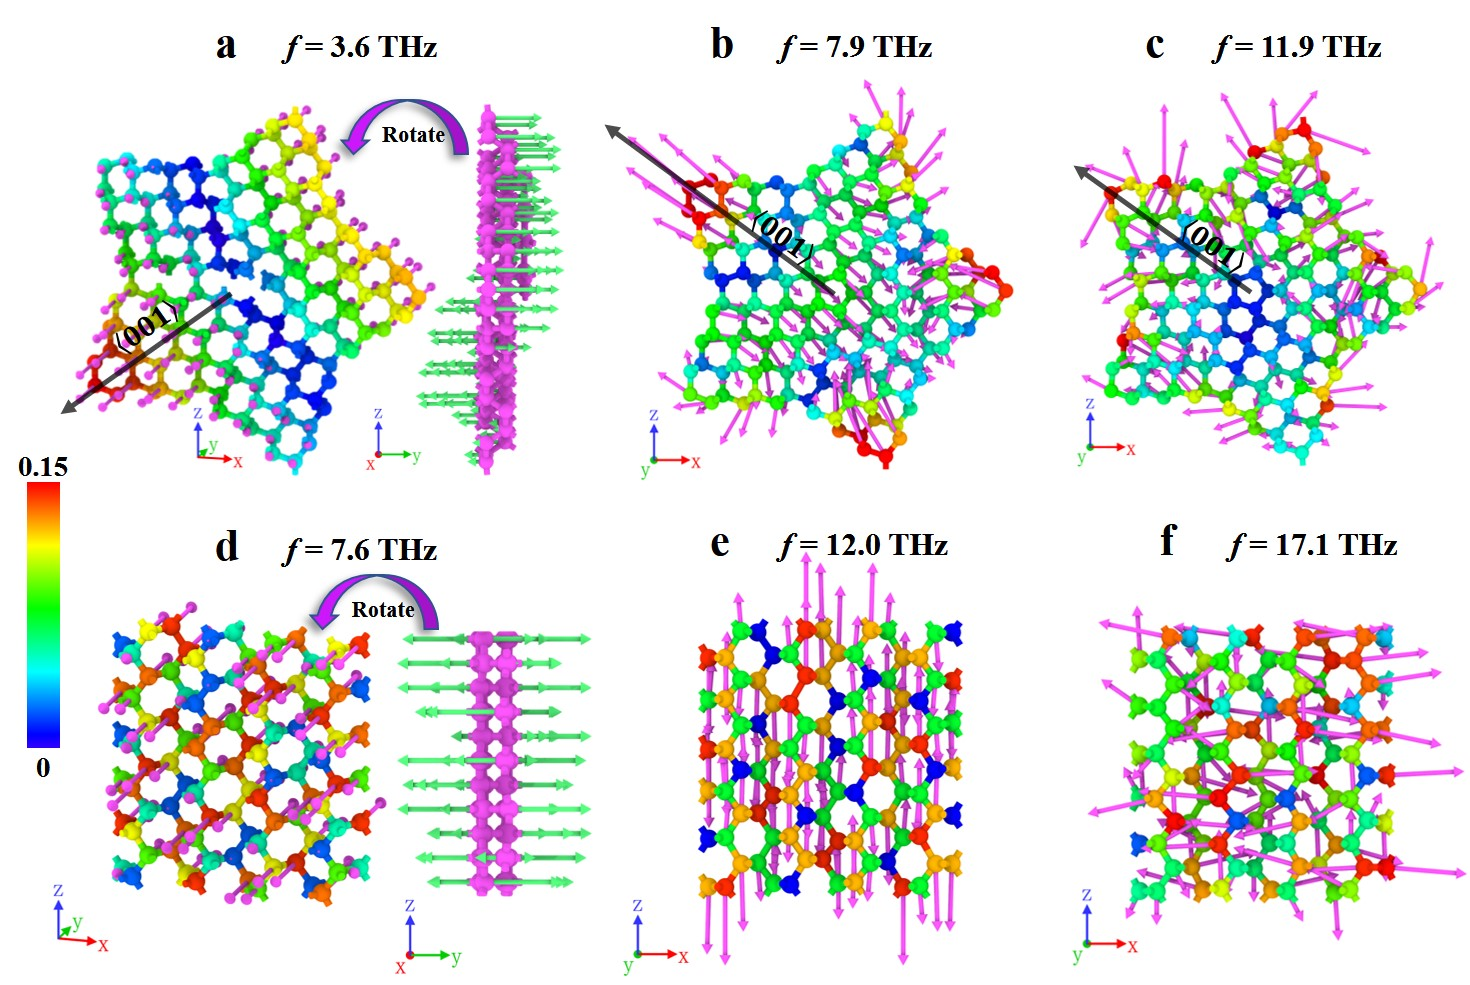

## Phonon dispersion
* Firstly, we need to calculate the phonon dispersion of 5FT-DNWs according the [tutorial](https://github.com/brucefan1983/GPUMD/blob/master/examples/empirical_potentials/phonon_dispersion/Phonon%20Dispersion.ipynb) in GPUMD.

### Preparing the Inputs
* Prepare the [POSCAR](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/Fivefold3_POSCAR) stucture of 5FT-DNWs. 
   ```
   POSCAR file written by Ovito Pro 3.0.0-dev766
   1
   23.2562 0.0 0.0
   0.0 2.51879944 0.0
   0.0 0.0 25.23005949
   C 
   155 
   Direct
   0.1879369979 0.4927654661 0.1812349976
   0.2814782523 -0.0066748506 0.1825856967
   0.3101087086 0.4934641362 0.2639057317
   0.2185915403 -0.0070519866 0.201853023
   ..............
   ```
   
* Then, the inputs/outputs for GPUMD are processed using the [Atomic Simulation Environment (ASE)](https://wiki.fysik.dtu.dk/ase/) and the [thermo](https://github.com/AlexGabourie/thermo) package.
   
  **Tips:** if one is using the [nep](https://github.com/brucefan1983/GPUMD/blob/master/examples/nep_potentials/PbTe/train/nep_tutorial.ipynb) in GPUMD, the [thermo](https://github.com/hityingph/thermo) package improved by top [Dr. Penghua](https://github.com/hityingph) should be used.
   
   
 * Next, importing Relevant Functions of [ASE](https://wiki.fysik.dtu.dk/ase/) and [thermo](https://github.com/AlexGabourie/thermo) package.
   

In [31]:
from pylab import *
from ase.io import read
from thermo.gpumd.preproc import add_basis, repeat
from thermo.gpumd.io import create_basis, create_kpoints, ase_atoms_to_gpumd

  * Read the [POSCAR](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/Fivefold3_POSCAR) file and prepare the input files for GPUMD

In [35]:
file_name = 'Fivefold3_POSCAR'
DNWs_unitcell = read(file_name)
DNWs_unitcell.center()
DNWs_unitcell.wrap()
DNWs_unitcell.pbc = [True, True, True]
DNWs_unitcell.write("lammps.data", format='lammps-data')    # Write the unitcell for eigenvector view (see later)
DNWs_unitcell

Atoms(symbols='C155', pbc=True, cell=[23.2562, 2.51879944, 25.23005949])

* Transform unitcell to supercell

In [23]:
add_basis(DNWs_unitcell)
DNWs = repeat(DNWs_unitcell, [1, 3, 1])   ## along y-axis

* Write [xyz.in](https://gpumd.zheyongfan.org/index.php/The_xyz.in_input_file) file

In [24]:
ase_atoms_to_gpumd(DNWs, M=500, cutoff=10)   # output xyz.in,see GPUMD for how to setup the M and cutoff

* Write [basis.in](https://gpumd.zheyongfan.org/index.php/The_basis.in_input_file) File, the detailed explaination for basis.in is available on [GPUMD](https://github.com/brucefan1983/GPUMD/blob/master/examples/empirical_potentials/phonon_dispersion/Phonon%20Dispersion.ipynb).

In [25]:
create_basis(DNWs)

* Write [kpoints.in](https://gpumd.zheyongfan.org/index.php/The_kpoints.in_input_file) File.
The $k$ vectors are defined in the reciprocal space with respect to the unit cell chosen in the basis.in file.
We use $\Gamma - Y$ the path, with 101 $k$ points in total. 


In [27]:
linear_path, sym_points, labels = create_kpoints(DNWs, path='GY', npoints=101)

  It is possible that the resulting kpoints.in file is wrong due to a problem with the create_kpoints function in ASE. One has to check the kpoints.in file when calculating the nanowires. The kpoints.in file for the $\Gamma - Y$ is as follows.
   ```
    101
    0 0 0
    0 0.0040967 0
    0 0.00819339 0
    0 0.0122901 0
    0 0.0163868 0
    0 0.0204835 0
    0 0.0245802 0
    0 0.0286769 0
    0 0.0327736 0
   ..............
   ```

* The [run.in](https://gpumd.zheyongfan.org/index.php/Main_Page) file:

        potential       potentials/tersoff/C_Tersoff_1989.txt    0 

        minimize         sd       1.0e-10    1000000    # For 5FT-DNWs 
        compute_phonon    16.0      0.005 				    # In units of A
        
* Then, run GPUMD, we can output the [omega2.out](https://gpumd.zheyongfan.org/index.php/The_omega2.out_output_file) file for ploting the phonon dispersion.
 
### Plot Phonon Dispersion
* Set figure properties


In [29]:
def set_fig_properties(ax_list):
    tl = 8
    tw = 2
    tlm = 4

    for ax in ax_list:
        ax.tick_params(which='major', length=tl, width=tw)
        ax.tick_params(which='minor', length=tlm, width=tw)
        ax.tick_params(which='both', axis='both', direction='in', right=True, top=True)

* Plot figures

The [omega2.out](https://gpumd.zheyongfan.org/index.php/The_omega2.out_output_file) output file is loaded and processed to create the following figure. The previously defined kpoints are used for the $x$-axis.

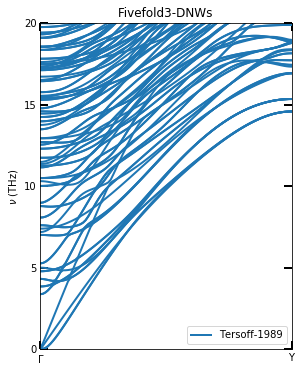

In [33]:
# load data
data = np.loadtxt("omega2.out")

for i in range(len(data)):
    for j in range(len(data[0])):

        data[i, j] = np.sqrt(abs(data[i, j])) / (2 * np.pi) * np.sign(data[i, j])

nu = data

# Plot
figure(figsize=(4.5, 6))
set_fig_properties([gca()])

# vlines(sym_points, ymin=-0.2, ymax=60, linestyle="--", colors="pink")
# print(nu[0, 4])      # For view

plot(linear_path, nu[:, 0], color='C0', lw=2, label="Tersoff-1989")
plot(linear_path, nu[:, 1:], color='C0', lw=2)
xlim([0, max(linear_path)])
gca().set_xticks(sym_points)
gca().set_xticklabels([r'$\Gamma$', 'Y', 'S', 'X', r'$\Gamma$'])
ylim([0, 20])                                   # or [0, 55] THz
gca().set_yticks(linspace(0, 20, 5))
ylabel(r'$\nu$ (THz)')
legend(frameon=True, loc="best")
title("Fivefold3-DNWs")
show()

* Since the phonon dispersion in the [Liang 2021](https://arxiv.org/ftp/arxiv/papers/2112/2112.13757.pdf) article was calculated using the force generated by [Lammps](https://www.lammps.org/) to [Phonopy](https://phonopy.github.io/phonopy/). The method of minimization used is different, so the phonon dispersion here is different from the [literature](https://arxiv.org/ftp/arxiv/papers/2112/2112.13757.pdf). However, the main features are the same. This may also be due to the lack of stability in the structure of 5FT-DNWs.

## Eigenvector.out (generate by [GPUMD](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file))

With the [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) file generated by GPUMD, we can obtain the eigenvector at $\Gamma$ points for their visualization on the atoms.

Please see the [GPUMD manual](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) for how to generate eigenvector.out. If you not only want to visualize the eigenvectors of $\Gamma$ point, you can diagonalize the [D.out](https://gpumd.zheyongfan.org/index.php/The_D.out_output_file) file by yourself.

* **Tips:** One can only modify the Kpoints.in file in following way：
    ```
    1
    0 0 0
    
    ```
  Thus, only one kpoint is included to this file. Then, one can rerun the GPUMD to obtain the [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file).
  
  
* **The size of [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) file is small because only the eigenvectors of $\Gamma$ point are output. Therefore, one can choose a structure with very large atom in unitcell for calculation.**

## View (generate the [lammps dump.file](https://docs.lammps.org/dump.html) and feed to [Ovito](https://www.ovito.org/about/))

### Run the [view_eigen_gpumd.py](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/view_eigen_gpumd.py) file
* Here, we will used the [view_eigen_gpumd.py](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/view_eigen_gpumd.py) file to process the [eigenvector.out](https://gpumd.zheyongfan.org/index.php/The_eigenvector.in_input_file) file and to generate the [dump.file](https://docs.lammps.org/dump.html) . 


* This dump file contains two frames with the position coordinates of the atoms, the first frame being the original atomic coordinates. The second frame is the atomic coordinates with the eigenvectors (**plus**). Thus, using ovtio's [Displacement vectors](file:///C:/Program%20Files/Ovito/doc/manual/html/display_objects.vectors.html) feature, we can visualize the eigenvectors. And with [Ovito](https://www.ovito.org/about/), we can output great looking images.


* In the following, we will describe two simple parameters that need to be modified in the [view_eigen_gpumd.py](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/view_eigen_gpumd.py).

In [ ]:
# %load view_eigen_gpumd.py
#!/usr/bin/env python3

"""
@author: LiangTing
2021/12/18 16:06:31
"""
import numpy as np
import os

def get_frequency_eigen_info(num_basis, eig_file='eigenvector.out', directory=None):

    if not directory:
        eig_path = os.path.join(os.getcwd(), eig_file)
    else:
        eig_path = os.path.join(directory, eig_file)

    eig_data_file = open(eig_path, 'r')
    data_lines = [line for line in eig_data_file.readlines() if line.strip()]
    eig_data_file.close()

    om2 = np.array([data_lines[0].split()[0:num_basis * 3]], dtype='float64')
    eigenvector = np.array([data_lines[1 + k].split()[0:num_basis * 3]
                                               for k in range(num_basis * 3)], dtype='float64')

    nu = np.sign(om2) * np.sqrt(abs(np.array(om2))) / (2 * np.pi)

    return nu, eigenvector

def read_from_lammps_structure_data(file_name='lammps-data', units='metal', number_of_dimensions=3):

    # Check file exists
    global column

    if not os.path.isfile(file_name):
        print('LAMMPS data file does not exist!')
        exit()

    # The column numbers depend by Lammps units
    if units == 'metal':
        column = 5
    elif units == 'real':
        column = 7

    # Read from Lammps data file
    # print("********************* The Structure is Reading *********************")
    lammps_file = open(file_name, 'r')
    data_lines = [line for line in lammps_file.readlines() if line.strip()]
    lammps_file.close()

    atom_num_in_box = int(data_lines[1].split()[0])

    direct_cell = np.array([data_lines[i].split()[0:2]
                                 for i in range(3, 3 + number_of_dimensions)], dtype='float64')

    positions_first_frame = np.array([data_lines[7 + k].split()[0:column]
                                           for k in range(atom_num_in_box)], dtype='float64')

    return atom_num_in_box, direct_cell, positions_first_frame

def position_plus_eigen(gamma_freq_points, nu, eigenvector, atom_num_in_box, positions_first_frame):
    import copy

    if atom_num_in_box * 3 != np.size(eigenvector, 1):
        raise ValueError("The data dimension of the eigenvector is inconsistent with atomic number*3")

    print('************* Now the frequency is {0:10.6} THz, the visualization of the eigenvectors is at gamma point'
          '**************** '.format(nu[0][gamma_freq_points]))

    positions_second_frame = copy.deepcopy(positions_first_frame)

    # reshape eigenvector
    eigenvector_x = eigenvector[gamma_freq_points][0:atom_num_in_box]
    eigenvector_y = eigenvector[gamma_freq_points][atom_num_in_box:atom_num_in_box*2]
    eigenvector_z = eigenvector[gamma_freq_points][atom_num_in_box*2:atom_num_in_box*3]

    for i in range(atom_num_in_box):
        positions_second_frame[i][2] = positions_first_frame[i][2] + eigenvector_x[i]  # x
        positions_second_frame[i][3] = positions_first_frame[i][3] + eigenvector_y[i]  # y
        positions_second_frame[i][4] = positions_first_frame[i][4] + eigenvector_z[i]  # z

    return positions_second_frame

def write_to_dump_File(atom_num_in_box, direct_cell, data, fmat, dump_step=1000, file_name='dump_for_visualization.eigen'):

    with open(file_name, fmat) as fid:
        fid.write('ITEM: TIMESTEP\n')
        fid.write('{} \n'.format(dump_step))
        fid.write('ITEM: NUMBER OF ATOMS\n')
        fid.write('{}\n'.format(atom_num_in_box))
        fid.write('ITEM: BOX BOUNDS pp pp pp\n')

        # Boundary
        for i in range(np.size(direct_cell, 0)):
            fid.write('{0:.10f}  {1:20.10f}\n'.format(direct_cell[i][0], direct_cell[i][1]))

        fid.write('ITEM: ATOMS id type x y z\n')
        for i in range(atom_num_in_box):
            fid.write('{0}   {1:.0f} {2:20.10f} {3:20.10f} {4:20.10f}\n'.format(i + 1, data[i][1],
                                                                                data[i][2],
                                                                                data[i][3],
                                                                                data[i][4]))
    fid.close()

def generate_file(freq, atom_num_in_box, direct_cell, positions_first_frame, positions_second_frame):

    # First frame
    file_name = str(round(freq, 4))+'THz_dump_for_visualization.eigen'
    write_to_dump_File(atom_num_in_box, direct_cell, positions_first_frame, fmat='w', dump_step=1000,
                       file_name=file_name)

    # second frame
    write_to_dump_File(atom_num_in_box, direct_cell, positions_second_frame, fmat='a', dump_step=2000,
                       file_name=file_name)

    print('************* dump_for_visualization.eigen is written successfully ************\n')

if __name__ == "__main__":

    num_basis = 155      ## number of atoms in unitcell
    nu, eigenvector = get_frequency_eigen_info(num_basis)
    atom_num_in_box, direct_cell, positions_first_frame = read_from_lammps_structure_data()

    # output
    gamma_freq_points = 4   ## The n-th frequency point on the Gamma point, depending on which frequency point you want to visualize.
    positions_second_frame = position_plus_eigen(gamma_freq_points, nu, eigenvector, atom_num_in_box, positions_first_frame)

    generate_file(nu[0][gamma_freq_points], atom_num_in_box, direct_cell, positions_first_frame, positions_second_frame)

    print('******************** All Done !!! *************************')

* **num_basis = 155** 

    This means that there are 155 atoms in the unitcell of 5FT-DNWs. We can obain it from [POSCAR](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/Fivefold3_POSCAR).
    

* **gamma_freq_points = 4**

    The 4-th frequency point on the $\Gamma$ point, depending on which frequency point you want to visualize.

In [37]:
%run view_eigen_gpumd.py

************* Now the frequency is    3.37745 THz, the visualization of the eigenvectors is at gamma point**************** 
************* dump_for_visualization.eigen is written successfully ************

******************** All Done !!! *************************


* Here, a dump file with the frequency name ([3.3775THz_dump_for_visualization.eigen](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/3.3775THz_dump_for_visualization.eigen)) would be generate. Then, one can use it to view the lattice vibration by using [Ovito](https://www.ovito.org/about/). 

### View the lattice vibration (using the [dump file](https://github.com/Tingliangstu/Phonon-Vibration-Viewer/blob/main/calculate%20phonon%20dispersion/3.3775THz_dump_for_visualization.eigen))

Learn to use ovito's [Displacement vectors](file:///C:/Program%20Files/Ovito/doc/manual/html/display_objects.vectors.html) feature. Eventually, we will get the diagram shown below.

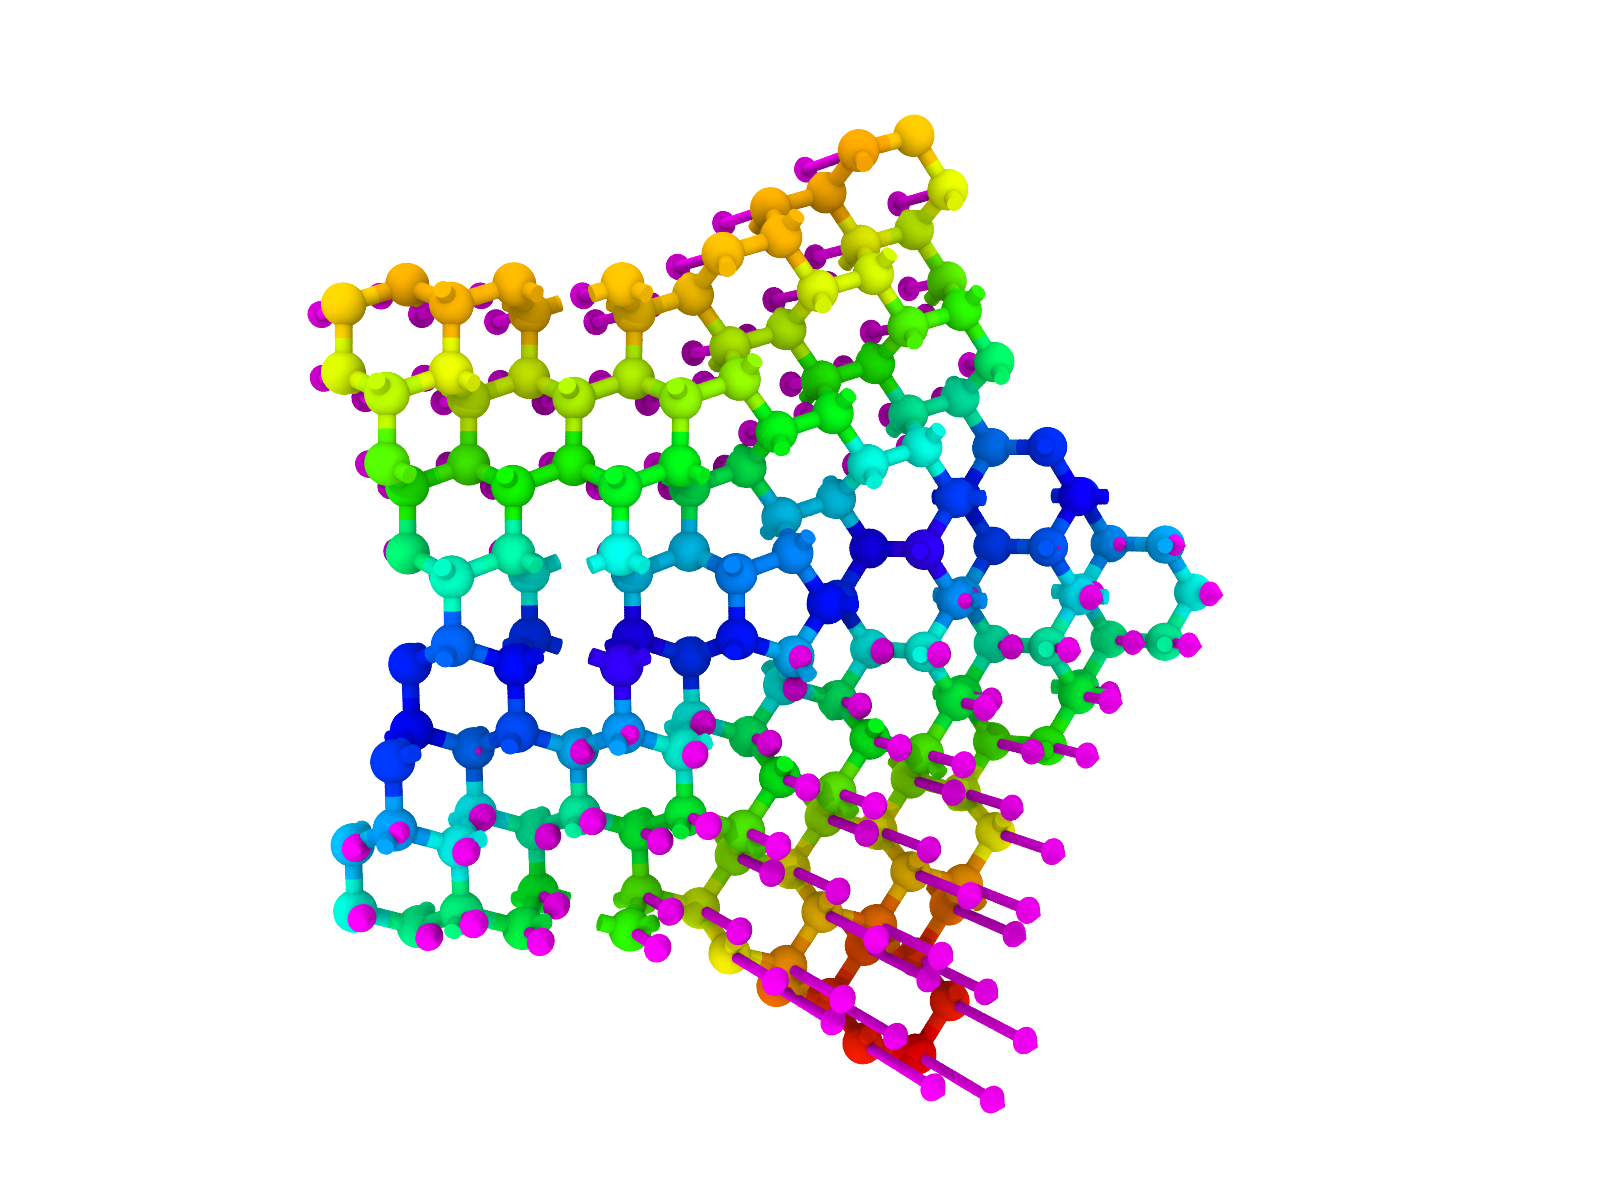

* This figure is almost indistinguishable from the one in [Liang 2021](https://arxiv.org/ftp/arxiv/papers/2112/2112.13757.pdf). Despite some deviations in the frequency points, the physical image presented is the same. Such frequency point deviations may be due to energy minimization or may be potential function dependent. But in the end, we reach the desired other side.

## References
* Liang T, Xu K, Han M, et al. [Abnormally High Thermal Conductivity in Fivefold Twinned Diamond Nanowires](https://arxiv.org/ftp/arxiv/papers/2112/2112.13757.pdf). arXiv preprint arXiv:2112.13757, 2021.
* Zhang L, Zhong Y, Qian X, et al. [Toward Optimal Heat Transfer of 2D–3D Heterostructures via van der Waals Binding Effects](https://pubs.acs.org/doi/abs/10.1021/acsami.1c08131). ACS Applied Materials & Interfaces, 2021, 13(38): 46055-46064.
* Sun Y, Zhou Y, Han J, et al.[ Strong phonon localization in PbTe with dislocations and large deviation to Matthiessen’s rule](https://www.nature.com/articles/s41524-019-0232-x). npj Computational Materials, 2019, 5(1): 1-6.
* Wang H, Cheng Y, Fan Z, et al. [Anomalous thermal conductivity enhancement in low dimensional resonant nanostructures due to imperfections](https://pubs.rsc.org/en/content/articlelanding/2021/NR/D1NR01679B). Nanoscale, 2021, 13(22): 10010-10015.
* Xiong S, Sääskilahti K, Kosevich Y A, et al. [Blocking phonon transport by structural resonances in alloy-based nanophononic metamaterials leads to ultralow thermal conductivity](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.117.025503). Physical review letters, 2016, 117(2): 025503.